In [ ]:
# %% [Cell 1] Imports, Type Definitions, and Global Configuration
import math
import time
import itertools
import os
import unittest
import random
from typing import List, Tuple, Dict, Any, Optional, Union

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import Callback
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns # Added for visualization

# --- Random seed management function ---
def set_global_seeds(seed=42):
    """Initialize random seeds for TensorFlow, NumPy, and Python random module."""
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_global_seeds(42)  # Set reproducible baseline for all subsequent operations

# --- Type Aliases for Clarity ---
ChoiceSet = Tuple[int, ...]  # Represents a tuple of item indices
ModelConfig = Dict[str, Any]

# --- Configuration ---
# Toggle this: True for quick unit testing (DEBUG), False for full paper reproduction.
DEBUG_MODE: bool = False

if DEBUG_MODE:
    print("⚠️ RUNNING IN DEBUG MODE: Small scale for verification.")
    CONFIG = {
        "universe_size": 5,         # J
        "choice_set_size": 3,       # K
        "obs_per_set": 10,
        "epochs": 5,
        "learning_rate": 1e-3,
        "batch_size": 32,
        "param_budgets": [500, 1000],
        "network_depths": [2, 3]    # L
    }
    DATA_FILENAME = "debug_data_final.npz"
else:
    print("🚨 RUNNING IN FULL MODE: Full scale paper reproduction.")
    CONFIG = {
        "universe_size": 20,
        "choice_set_size": 15,
        "obs_per_set": 80,
        "epochs": 100,
        "learning_rate": 1e-4,
        "batch_size": 1024,
        "param_budgets": [200000, 500000],
        "network_depths": [3, 4, 5, 6, 7]
    }
    DATA_FILENAME = "full_scale_data_final.npz"

🚨 RUNNING IN FULL MODE: Full scale paper reproduction.


In [ ]:
# %% [Cell 2] Helper Function: Architecture Constraint Solver

def calculate_layer_width(
    network_depth: int,
    target_param_count: int,
    universe_size: int
) -> int:
    """
    Calculates the optimal number of neurons per hidden layer to satisfy a total parameter constraint.

    This function solves the quadratic equation derived from the ResNet architecture parameter count:
        (Depth - 1) * width^2 + 2 * universe_size * width - target_params = 0

    Args:
        network_depth (int): The number of layers in the network (L). Must be >= 1.
        target_param_count (int): The maximum allowable number of parameters (Budget).
        universe_size (int): The total number of unique items in the discrete choice set (J).

    Returns:
        int: The calculated width (number of neurons) for the hidden layers. Returns 0 if no valid solution exists.

    Raises:
        ValueError: If network_depth is less than 1.
    """
    if network_depth < 1:
        raise ValueError(f"Network depth must be >= 1, got {network_depth}")

    # Coefficients for the quadratic equation: ax^2 + bx + c = 0
    quad_coeff_a = network_depth - 1
    lin_coeff_b = 2 * universe_size
    const_coeff_c = -target_param_count

    # Handle linear model case (Depth=1)
    if quad_coeff_a == 0:
        return int(target_param_count / lin_coeff_b) if lin_coeff_b > 0 else 0

    discriminant = lin_coeff_b**2 - 4 * quad_coeff_a * const_coeff_c

    if discriminant < 0:
        return 0

    # Quadratic formula
    width = (-lin_coeff_b + math.sqrt(discriminant)) / (2 * quad_coeff_a)

    return int(width)

In [ ]:
# %% [Cell 3] Data Pipeline: Generation and Loading

def generate_synthetic_choice_data(
    universe_size: int,
    choice_set_size: int,
    obs_per_set: int,
    filepath: str
) -> Tuple[np.ndarray, np.ndarray, Dict[ChoiceSet, np.ndarray], List[ChoiceSet]]:
    """
    Generates or loads synthetic discrete choice data based on a Dirichlet-Multinomial process.

    This function ensures that every possible combination of the choice set is generated exactly once
    to form a complete 'ground truth' dataset.

    Args:
        universe_size (int): Total number of items available (J).
        choice_set_size (int): Number of items in each choice set (K).
        obs_per_set (int): Number of simulated user choices per choice set.
        filepath (str): Path to the .npz file for caching results.

    Returns:
        Tuple containing:
            - availability_vectors (np.ndarray): Input features (One-hot encoding of available items).
            - selection_vectors (np.ndarray): Target labels (One-hot encoding of chosen items).
            - empirical_freqs (Dict): Mapping of ChoiceSet tuple to empirical probability distribution.
            - all_choice_sets (List): List of all unique choice set tuples.
    """

    # 1. Check Cache
    if os.path.exists(filepath):
        print(f"Loading cached data from {filepath}...")
        data = np.load(filepath, allow_pickle=True)

        # Reconstruct complex objects from numpy arrays
        empirical_freqs = data['empirical_freqs'].item()
        # Ensure keys are tuples (immutable) for dictionary lookup
        choice_sets_list = [tuple(cs) for cs in data['choice_sets']]

        return data['X'], data['y'], empirical_freqs, choice_sets_list

    # 2. Setup Generators
    print("Cache not found. initializing data generation...")
    try:
        total_combinations = math.comb(universe_size, choice_set_size)
    except AttributeError:
        # For Python < 3.8 compatibility if needed
        import scipy.special
        total_combinations = int(scipy.special.comb(universe_size, choice_set_size))

    print(f"Generating {total_combinations} unique choice sets. This may take time.")

    item_indices = range(universe_size)
    # Create a generator for all possible combinations C(J, K)
    combination_generator = itertools.combinations(item_indices, choice_set_size)

    availability_vectors = []
    selection_vectors = []
    empirical_freqs = {}

    # Dirichlet distribution for generating ground truth probabilities
    # Concentration = 1 implies a uniform prior over the simplex
    dirichlet_dist = tfp.distributions.Dirichlet(concentration=tf.ones(choice_set_size))

    # 3. Main Generation Loop
    for current_set in tqdm(combination_generator, total=total_combinations, desc="Processing Combinations"):
        current_set_tuple = tuple(current_set)

        # Create input feature: Vector of size J where 1 indicates item is available
        avail_vec = np.zeros(universe_size, dtype='float32')
        avail_vec[list(current_set)] = 1.0

        # Sample Ground Truth probabilities for this specific set
        true_probs = dirichlet_dist.sample().numpy()

        # Simulate agent choices based on Ground Truth
        simulated_choices_indices = np.random.choice(
            choice_set_size,
            size=obs_per_set,
            p=true_probs
        )

        # Record empirical frequencies (Ground Truth for Validation RMSE)
        counts = np.bincount(simulated_choices_indices, minlength=choice_set_size)
        empirical_freqs[current_set_tuple] = counts / obs_per_set

        # Generate Training Pairs (X, y)
        for relative_index in simulated_choices_indices:
            # Map relative index (0..K-1) back to absolute item index (0..J-1)
            absolute_item_index = current_set_tuple[relative_index]

            label_vec = np.zeros(universe_size, dtype='float32')
            label_vec[absolute_item_index] = 1.0

            availability_vectors.append(avail_vec)
            selection_vectors.append(label_vec)

    # 4. Finalize and Save
    X_final = np.array(availability_vectors)
    y_final = np.array(selection_vectors)
    choice_sets_final = list(empirical_freqs.keys())

    print(f"Saving generated data to {filepath}...")
    np.savez_compressed(
        filepath,
        X=X_final,
        y=y_final,
        empirical_freqs=empirical_freqs,
        choice_sets=choice_sets_final
    )

    return X_final, y_final, empirical_freqs, choice_sets_final

In [ ]:
# %% [Cell 4] Model Definition: Featureless DeepHalo

def build_featureless_deep_halo_model(
    universe_size: int,
    hidden_width: int,
    network_depth: int
) -> models.Model:
    """
    Constructs the DeepHalo neural network architecture designed for featureless discrete choice.

    Key Architectural Features:
    1.  **Quadratic Activation**: Uses x^2 instead of ReLU to explicitly model interaction effects.
    2.  **ResNet Topology**: Uses skip connections for gradient flow.
    3.  **Availability Masking**: Ensures probability of unavailable items is strictly zero.

    Args:
        universe_size (int): Size of the item universe (Input/Output dimension).
        hidden_width (int): Number of neurons in hidden layers.
        network_depth (int): Total number of non-linear transformations.

    Returns:
        models.Model: A compiled Keras functional model.
    """

    # Input: Binary vector indicating item availability
    inputs = layers.Input(shape=(universe_size,), name='Availability_Input')

    # Initial Projection: Linear mapping to hidden dimension
    # Note: use_bias=False is used to adhere strictly to parameter budget constraints logic
    x = layers.Dense(hidden_width, use_bias=False, name='Projection_Layer')(inputs)

    # Stacked Residual Blocks
    for i in range(1, network_depth + 1):
        # Identity path
        shortcut = x

        # Quadratic Activation: Explicitly models pairwise interactions
        x = layers.Lambda(lambda t: tf.square(t), name=f'Quadratic_Activation_{i}')(x)

        # Linear Transformation (Mixing)
        x = layers.Dense(hidden_width, use_bias=False, name=f'Mixing_Layer_{i}')(x)

        # Residual Connection
        x = layers.Add(name=f'Residual_Add_{i}')([shortcut, x])

    # Output Projection: Map back to item universe size
    logits = layers.Dense(universe_size, use_bias=False, name='Logit_Projection')(x)

    # --- Masking Mechanism ---
    # We must ensure the model cannot assign probability to items not in the input set.
    # 1. Cast input (0/1 floats) to boolean mask
    mask_boolean = layers.Lambda(
        lambda t: tf.cast(t, dtype=tf.bool),
        name='Create_Boolean_Mask'
    )(inputs)

    # 2. Apply Mask: Replace logits of unavailable items with -1e9 (approx negative infinity)
    # This ensures exp(logit) is effectively 0 during Softmax
    masked_logits = layers.Lambda(
        lambda args: tf.where(args[0], args[1], -1e9),
        output_shape=(universe_size,),
        name='Apply_Availability_Mask'
    )([mask_boolean, logits])

    # Probability Output
    outputs = layers.Softmax(name='Probability_Distribution')(masked_logits)

    return models.Model(inputs=inputs, outputs=outputs, name="DeepHalo_Model")

In [ ]:
# %% [Cell 5] Evaluation Callback: Distribution Matching

class DistributionMatchingRMSECallback(Callback):
    """
    A custom Keras Callback to evaluate the Root Mean Squared Error (RMSE)
    between predicted probabilities and ground-truth empirical frequencies.

    Unlike standard validation which checks single-sample accuracy, this callback:
    1. Iterates through ALL unique choice sets.
    2. Predicts the full probability distribution for each set.
    3. Compares it against the true Dirichlet distribution from data generation.
    """

    def __init__(
        self,
        unique_choice_sets: List[ChoiceSet],
        empirical_distributions: Dict[ChoiceSet, np.ndarray],
        check_interval: int = 10
    ):
        """
        Initialize the callback.

        Args:
            unique_choice_sets (List[ChoiceSet]): List of all unique choice set tuples.
            empirical_distributions (Dict): Lookup table for ground truth probabilities.
            check_interval (int): Epoch frequency to run this expensive calculation.
        """
        super().__init__()
        self.unique_choice_sets = unique_choice_sets
        self.empirical_distributions = empirical_distributions
        self.check_interval = check_interval
        self.rmse_history: List[float] = []

    def on_epoch_end(self, epoch: int, logs: Optional[Dict] = None):
        # Skip evaluation if not the correct interval
        if (epoch + 1) % self.check_interval != 0:
            return

        # Accumulator for squared errors
        batch_squared_errors = []

        # NOTE: We iterate one by one for clarity, but batched inference
        # would be used in a production environment for speed.
        for choice_set in self.unique_choice_sets:
            # Construct input vector for this specific choice set
            input_vec = np.zeros((1, self.model.input_shape[1]), dtype='float32')
            input_vec[0, list(choice_set)] = 1.0

            # Get model prediction
            pred_probs = self.model.predict(input_vec, verbose=0)[0]

            # Filter predictions to only relevant items
            relevant_preds = pred_probs[list(choice_set)]

            # Get Ground Truth
            true_freqs = self.empirical_distributions[choice_set]

            # Compute Squared Error for this set
            error = np.square(relevant_preds - true_freqs)
            batch_squared_errors.append(np.mean(error))

        # Compute global RMSE
        current_rmse = np.sqrt(np.mean(batch_squared_errors))
        self.rmse_history.append(current_rmse)

        print(f" — [Epoch {epoch+1}] Validation Distribution RMSE: {current_rmse:.6f}")

In [ ]:
# %% [Cell 6] Experiment Orchestration

def run_comparative_experiment(
    x_data: np.ndarray,
    y_data: np.ndarray,
    empirical_lookup: Dict,
    choice_sets_list: List,
    config: ModelConfig
) -> Dict[int, Dict[int, Any]]:
    """
    Orchestrates the training of multiple models across different parameter budgets and depths.

    Args:
        x_data (np.ndarray): Training features.
        y_data (np.ndarray): Training labels.
        empirical_lookup (Dict): Ground truth data for validation.
        choice_sets_list (List): List of choice sets for validation.
        config (ModelConfig): Dictionary containing hyperparameters.

    Returns:
        Dict: Nested dictionary containing experiment results keyed by [Budget][Depth].
    """
    experiment_results = {}

    # Determine validation frequency
    validation_interval = 1 if DEBUG_MODE else 50

    for budget in config["param_budgets"]:
        experiment_results[budget] = {}

        for depth in config["network_depths"]:
            print(f"\n{'='*40}")
            print(f"Experiment: Budget={budget}, Depth={depth}")
            print(f"{'='*40}")

            # 1. Calculate Topology Constraints
            layer_width = calculate_layer_width(
                network_depth=depth,
                target_param_count=budget,
                universe_size=config["universe_size"]
            )

            if layer_width <= 0:
                print(f"Skipping configuration: Cannot satisfy budget {budget} with depth {depth}.")
                continue

            print(f"-> Architecture: {layer_width} neurons per layer.")

            # 2. Initialize Model
            model = build_featureless_deep_halo_model(
                universe_size=config["universe_size"],
                hidden_width=layer_width,
                network_depth=depth
            )

            # 3. Compile
            # We use MSE because we are regressing towards a probability distribution
            model.compile(
                optimizer=optimizers.Adam(learning_rate=config["learning_rate"]),
                loss='mean_squared_error'
            )

            # 4. Setup Validator
            rmse_validator = DistributionMatchingRMSECallback(
                unique_choice_sets=choice_sets_list,
                empirical_distributions=empirical_lookup,
                check_interval=validation_interval
            )

            # 5. Train
            model.fit(
                x_data, y_data,
                batch_size=config["batch_size"],
                epochs=config["epochs"],
                callbacks=[rmse_validator],
                verbose=0  # Suppress default Keras bar to keep output clean
            )

            # 6. Log Results
            final_score = rmse_validator.rmse_history[-1] if rmse_validator.rmse_history else 0.0
            experiment_results[budget][depth] = {
                'rmse_history': rmse_validator.rmse_history,
                'final_rmse': final_score,
                'layer_width': layer_width
            }
            print(f"-> Result: Final RMSE = {final_score:.5f}")

    return experiment_results

In [ ]:
# %% [Cell 7] Visualization of Results

def plot_performance_metrics_repro(results_data: Dict, depths: List[int], is_debug: bool):
    """
    Plots the comparative results
    """
    # --- Setup Style ---
    sns.set_theme(style="whitegrid", font_scale=1.1)
    check_interval = 1 if is_debug else 50
    budgets = sorted(results_data.keys())
    n_depths = len(depths)

    # Define Gradient Palettes
    blues_palette = sns.color_palette("Blues", n_colors=n_depths + 2)[2:]
    oranges_palette = sns.color_palette("YlOrBr", n_colors=n_depths + 2)[2:]

    # Map Budget -> Palette
    palette_map = {
        budgets[0]: blues_palette,      # e.g. 200k or 500 (debug)
        budgets[1]: oranges_palette     # e.g. 500k or 1000 (debug)
    } if len(budgets) >= 2 else {budgets[0]: blues_palette}

    # ==========================================
    # Figure: Effect of Model Depth
    # ==========================================
    plt.figure(figsize=(8, 6))

    # Line Styles
    styles = {
        budgets[0]: {'color': '#4c72b0', 'marker': 'o', 'label': f'{int(budgets[0]/1000)}k'},
        budgets[1]: {'color': '#dd8452', 'marker': '*', 'label': f'{int(budgets[1]/1000)}k'}
    } if len(budgets) >= 2 else {budgets[0]: {'color': '#4c72b0', 'marker': 'o', 'label': str(budgets[0])}}

    for budget in budgets:
        # Extract y-values (RMSE) for x-axis (Depths)
        rmse_values = []
        valid_depths = []
        for d in depths:
            if d in results_data[budget]:
                rmse_values.append(results_data[budget][d]['final_rmse'])
                valid_depths.append(d)

        # Plot Line
        plt.plot(
            valid_depths,
            rmse_values,
            marker=styles[budget]['marker'],
            color=styles[budget]['color'],
            label=styles[budget]['label'],
            linewidth=1.5,
            markersize=6
        )

    plt.xlabel('Depth')
    plt.ylabel('Training RMSE')
    plt.xticks(depths)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ==========================================
    # Figure: Training Loss Curve Across Epochs
    # ==========================================
    plt.figure(figsize=(10, 7))

    for b_idx, budget in enumerate(budgets):
        current_palette = palette_map[budget]

        # Sort depths to ensure color gradient matches depth order
        sorted_experiment_depths = sorted(results_data[budget].keys())

        for i, depth in enumerate(sorted_experiment_depths):
            history = results_data[budget][depth]['rmse_history']
            epochs_x = np.arange(1, len(history) + 1) * check_interval

            # Assign color from palette based on depth index
            # If debug mode has fewer depths, we pick from the beginning of palette
            color = current_palette[i] if i < len(current_palette) else current_palette[-1]

            label_str = f"{int(budget/1000)}k Dep {depth}"

            plt.plot(
                epochs_x,
                history,
                color=color,
                label=label_str,
                linewidth=1.5,
                alpha=0.9
            )

    plt.xlabel('Epochs')
    plt.ylabel('Training RMSE')

    # Create a legend that fits well (top right)
    plt.legend(loc='upper right', frameon=True, framealpha=0.9)
    plt.grid(True, which='major', alpha=0.6)
    plt.tight_layout()
    plt.show()

In [ ]:
# %% [Cell 8] Formal Unit Testing
# Define the Test Case Class inheriting from unittest.TestCase
class TestDeepHaloReproduction(unittest.TestCase):
    """
    Comprehensive Test Suite for the DeepHalo reproduction project.
    Follows the standard 'unittest' framework methodology.
    """

    def setUp(self):
        """
        Fixture Setup: Runs before EACH test method.
        Sets up a controlled environment (small constants, temp filenames).
        """
        self.test_universe_size = 10
        self.test_choice_set_size = 4
        self.test_obs_per_set = 50
        self.test_filename = "test_suite_temp_data.npz"

        # Define a valid dummy config for model building
        self.model_config = {
            "universe_size": 5,
            "hidden_width": 8,
            "network_depth": 3
        }

    def tearDown(self):
        """
        Fixture Teardown: Runs after EACH test method.
        Cleans up artifacts (like temporary .npz files) to ensure isolation.
        """
        if os.path.exists(self.test_filename):
            os.remove(self.test_filename)

    def test_calculate_layer_width_logic(self):
        """
        Test Case: Verify the quadratic equation solver for layer width.
        Reference: calculate_layer_width() function.
        """
        # Case 1: Standard inputs
        width = calculate_layer_width(network_depth=3, target_param_count=2000, universe_size=20)
        self.assertGreater(width, 0, "Calculated width should be positive for valid inputs.")
        self.assertIsInstance(width, int, "Width should be returned as an integer.")

        # Case 2: Zero depth (should raise ValueError)
        with self.assertRaises(ValueError):
            calculate_layer_width(network_depth=0, target_param_count=1000, universe_size=20)

        # Case 3: Impossible budget (should return 0)
        width_impossible = calculate_layer_width(network_depth=5, target_param_count=10, universe_size=100)
        self.assertEqual(width_impossible, 0, "Should return 0 if budget is too small for architecture.")

    def test_data_generation_integrity(self):
        """
        Test Case: Verify data generation pipeline dimensions and caching.
        Reference: generate_synthetic_choice_data() function.
        """
        # Generate data
        X, y, freqs, choices = generate_synthetic_choice_data(
            self.test_universe_size,
            self.test_choice_set_size,
            self.test_obs_per_set,
            self.test_filename
        )

        # Check 1: File creation
        self.assertTrue(os.path.exists(self.test_filename), "Data file was not created.")

        # Check 2: Shape consistency
        # X shape should be (N_samples, Universe_Size)
        self.assertEqual(X.shape[1], self.test_universe_size, "Input feature dimension mismatch.")
        self.assertEqual(X.shape[0], y.shape[0], "X and y must have same number of samples.")

        # Check 3: Combinatorial Logic
        # Expected number of unique sets = C(10, 4) = 210
        expected_combinations = math.comb(self.test_universe_size, self.test_choice_set_size)
        self.assertEqual(len(choices), expected_combinations, "Did not generate all unique combinations.")

    def test_model_architecture_spec(self):
        """
        Test Case: Verify Keras model construction, input/output shapes, and naming.
        Reference: build_featureless_deep_halo_model() function.
        """
        model = build_featureless_deep_halo_model(
            universe_size=self.model_config["universe_size"],
            hidden_width=self.model_config["hidden_width"],
            network_depth=self.model_config["network_depth"]
        )

        # Check 1: Output Shape matches Universe Size (Probability over items)
        output_shape = model.output_shape
        # Keras output shape is usually (None, J)
        self.assertEqual(output_shape[1], self.model_config["universe_size"],
                         "Model output layer dimension is incorrect.")

        # Check 2: Layer Naming (Critical for debugging)
        layer_names = [layer.name for layer in model.layers]
        self.assertIn("Availability_Input", layer_names)
        self.assertIn("Quadratic_Activation_1", layer_names, "Missing quadratic activation layer.")
        self.assertIn("Apply_Availability_Mask", layer_names, "Missing masking mechanism.")

# ==========================================
# RUNNING UNITTEST
# ==========================================
if __name__ == '__main__':
    print("Running Formal Unit Tests...")
    # This trick runs unittest.main() without exiting the Jupyter kernel
    unittest.main(argv=['first-arg-is-ignored'], verbosity=2, exit=False)

test_calculate_layer_width_logic (__main__.TestDeepHaloReproduction.test_calculate_layer_width_logic)
Test Case: Verify the quadratic equation solver for layer width. ... ok
test_data_generation_integrity (__main__.TestDeepHaloReproduction.test_data_generation_integrity)
Test Case: Verify data generation pipeline dimensions and caching. ... 

Running Formal Unit Tests...
Cache not found. initializing data generation...
Generating 210 unique choice sets. This may take time.


Processing Combinations:   0%|          | 0/210 [00:00<?, ?it/s]

ok
test_model_architecture_spec (__main__.TestDeepHaloReproduction.test_model_architecture_spec)
Test Case: Verify Keras model construction, input/output shapes, and naming. ... ok

----------------------------------------------------------------------
Ran 3 tests in 1.995s

OK


Saving generated data to test_suite_temp_data.npz...


--- STARTING FULL PIPELINE (DEBUG_MODE=False) ---

>>> STEP 1: Preparing Data...
Loading cached data from full_scale_data_final.npz...

>>> STEP 2: Running Comparative Experiments...

Experiment: Budget=200000, Depth=3
-> Architecture: 306 neurons per layer.
 — [Epoch 50] Validation Distribution RMSE: 0.051376
 — [Epoch 100] Validation Distribution RMSE: 0.041024
-> Result: Final RMSE = 0.04102

Experiment: Budget=200000, Depth=4
-> Architecture: 251 neurons per layer.
 — [Epoch 50] Validation Distribution RMSE: 0.044581
 — [Epoch 100] Validation Distribution RMSE: 0.036066
-> Result: Final RMSE = 0.03607

Experiment: Budget=200000, Depth=5
-> Architecture: 218 neurons per layer.
 — [Epoch 50] Validation Distribution RMSE: 0.041386
 — [Epoch 100] Validation Distribution RMSE: 0.035300
-> Result: Final RMSE = 0.03530

Experiment: Budget=200000, Depth=6
-> Architecture: 196 neurons per layer.
 — [Epoch 50] Validation Distribution RMSE: 0.040221
 — [Epoch 100] Validation Distribution RMSE

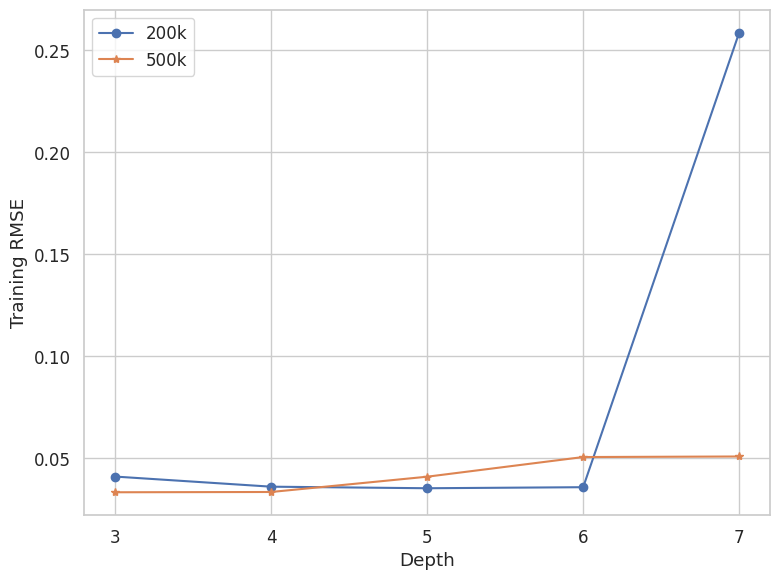

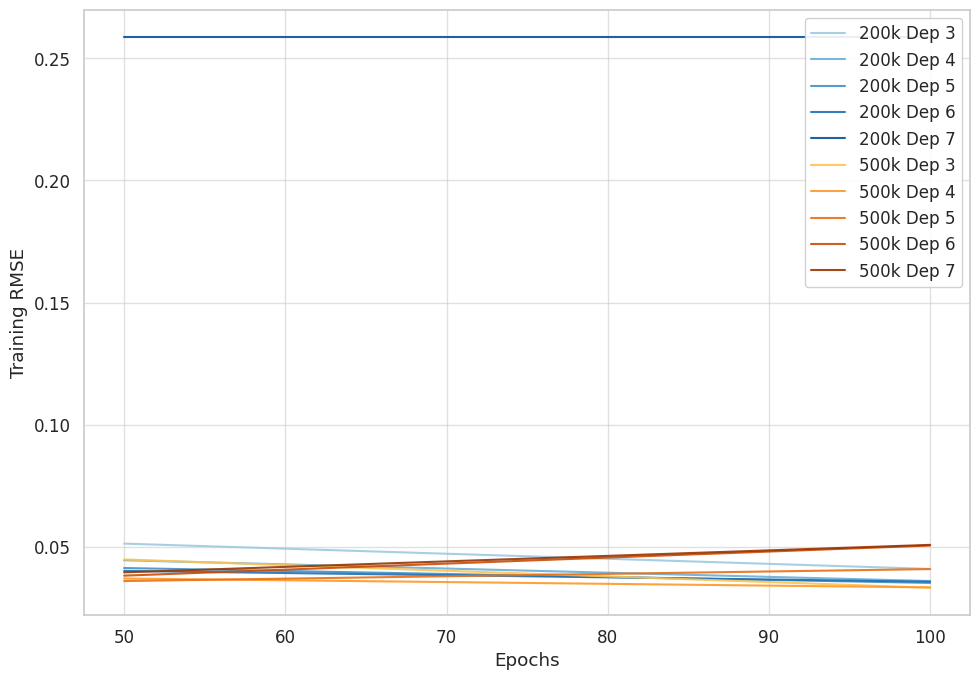


--- PIPELINE COMPLETED in 25742.01 seconds ---


In [ ]:
# %% [Cell 9] FINAL EXECUTION PIPELINE

total_start_time = time.time()
print(f"--- STARTING FULL PIPELINE (DEBUG_MODE={DEBUG_MODE}) ---")

# 1. Load/Generate Data (Uses CONFIG settings from Cell 1)
print("\n>>> STEP 1: Preparing Data...")
X_train, y_train, empirical_freqs, all_choice_sets = generate_synthetic_choice_data(
    CONFIG["universe_size"],
    CONFIG["choice_set_size"],
    CONFIG["obs_per_set"],
    DATA_FILENAME
)

# 2. Run Experiments (Uses functions defined in Cells 5 & 6)
print("\n>>> STEP 2: Running Comparative Experiments...")
experiment_results = run_comparative_experiment(
    X_train,
    y_train,
    empirical_freqs,
    all_choice_sets,
    CONFIG
)

# 3. Plot Results (Uses function defined in Cell 7)
print("\n>>> STEP 3: Visualizing Results...")
# Pass the global DEBUG_MODE to the plotter for correct check interval calculation
plot_performance_metrics_repro(experiment_results, CONFIG["network_depths"], DEBUG_MODE)

print(f"\n--- PIPELINE COMPLETED in {time.time() - total_start_time:.2f} seconds ---")